# FINAL REPORT WITH OUR ENTIRE APPROACH

This report documents the complete end-to-end pipeline for predicting employee attrition: data collection and ethics, preprocessing, exploratory analysis, model selection and training, performance evaluation, and final recommendations for HR decision-making.

### Table of contents : 


* 1. [ETHICS](#ethics)
* 2. [RAW DATASET DESCRIPTION](#raw-dataset-description)
* 3. [DATA WRANGLING](#data-wrangling)
* 4. [CHOICE OF AI MODEL](#choice-of-ai-model)
* 5. [MODEL APPLICATION](#model-application)
* 6. [RESULT ANALYSIS](#result-analysis)
* 7. [OPTIMISATION STEPS](#optimisation-steps)
* 8. [SELECTED MODEL AFTER COMPARING](#selected-model-after-comparing)
* 9. [ANALYSIS OF RESULTS](#analysis-of-results)
* 10. [RECOMMENDATIONS](#recommendations)

## 1. ETHICS

**Approach:** We removed identifiers and sensitive attributes to reduce privacy risks and potential algorithmic bias.

**Columns removed for ethical reasons:**
- **Identifiers (PII):** `EmployeeID` (unique person ID)
- **Protected attributes:** `Gender`, `Age`, `MaritalStatus` (to prevent discrimination based on protected characteristics)
- **Constant/redundant:** `Over18_Y`, `EmployeeCount`, `StandardHours` (zero variance—no predictive value)

**Trade-offs:** Removing `Age` and `Gender` reduces direct bias but may remove proxies. We accept this trade-off to prioritize fairness and privacy.

**Limitations:** The model may still exhibit disparate impact through correlated features. Continuous monitoring in production is recommended.

**Key ethical decisions documented above.** See full justification and monitoring plan in the **FINAL MODEL AND JUSTIFICATION** section.

## 2. RAW DATASET DESCRIPTION 

**Data sources:**
- `general_data.csv` — main HR dataset containing employee demographics, job role, compensation, and performance metrics
- `manager_survey_data.csv` — management feedback on employees job involvement and performance rating
- `employee_survey_data.csv` — supplementary survey responses on job satisfaction, work-life balance, and environment satisfaction

**Dataset statistics:**
- Rows: 4410 employees (after merging)
- Columns: 30+ features covering demographics, compensation, tenure, and survey responses
- Target variable: `Attrition` (binary: 1 = Left, 0 = Stayed)
- Target distribution: class imbalance (~16% attrition rate)
- Missing values: handled via median imputation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 

In [5]:
extract_path = 'dataset'

# Assuming the extracted file is a CSV file named 'housing.csv'
csv_file_path = os.path.join(extract_path, 'general_data.csv')

# Load the dataset
general_data = pd.read_csv(csv_file_path)
general_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [3]:
general_data.head()


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


## 3. DATA WRANGLING

**Pipeline steps:**

1. **Load & Merge:** concatenated `general_data.csv` and `manager_survey_data.csv` along axis 1 (side-by-side, same employee order).

2. **Numeric Imputation:** used `SimpleImputer(strategy='median')` to fill missing values in numeric columns. Median is robust to outliers.

3. **Categorical Encoding:** applied `OneHotEncoder(sparse_output=False, handle_unknown='ignore')` to categorical features; new columns created for each category (e.g., `Department_Sales`, `Department_HR`).

4. **Standardization:** scaled numeric features using `StandardScaler` (zero mean, unit variance). Essential for distance-based and regularized models.

5. **Ethical Filtering:** dropped PII and protected attributes (see **ETHICS** section).

**Final dataset shape:** 4,410 rows × 46 features (after encoding and filtering). Attrition encoded as 0/1.

## 4. CHOICE OF AI MODEL 

**Candidate algorithms tested:**
- **Logistic Regression** — interpretable baseline; fast training.
- **Support Vector Machine (SVM)** — strong on high-dimensional data.
- **k-Nearest Neighbors (KNN)** — simple non-parametric method.
- **Naive Bayes** — probabilistic model; assumes feature independence.
- **Decision Tree** — highly interpretable; prone to overfitting.
- **Random Forest** — ensemble; robust and provides feature importance.
- **Perceptron** — simple linear classifier; baseline for comparison.

**Primary evaluation metric:** Recall (minimizing false negatives—catching true leavers) prioritized; balanced with Precision and ROC AUC.

**Imbalance handling:** applied `class_weight='balanced'` to penalize misclassifying the minority class (attrition).

## 5. MODEL APPLICATION  

**Data split:** 80% train (3,528 samples) / 20% test (882 samples) using `train_test_split(..., test_size=0.2, random_state=42)`.

**Model training:**
- Fitted each algorithm on scaled and encoded training data.
- Applied `class_weight='balanced'` to Logistic Regression and SVM to handle class imbalance.
- Random Forest trained with `n_estimators=100`.

**Reproducibility notes:**
- Random seed: 42 (for train/test split and model initialization)
- All models trained on the same feature set post-preprocessing.

## 6. RESULT ANALYSIS

**Evaluation metrics computed:**
- **Accuracy** — overall correctness (not ideal for imbalanced data; reference only).
- **Precision** — among predicted attritions, how many truly left (minimize false alarms).
- **Recall** — among actual leavers, how many we caught (minimize missed detections).
- **F1-score** — harmonic mean balancing precision and recall.
- **ROC AUC** — area under the receiver operating characteristic curve.

**Key findings:** Random Forest and Logistic Regression achieved highest recall; Random Forest offers better separability (higher AUC). Trade-off: higher recall catches more leavers but increases false alarms. Choose threshold based on HR tolerance for false positives.  

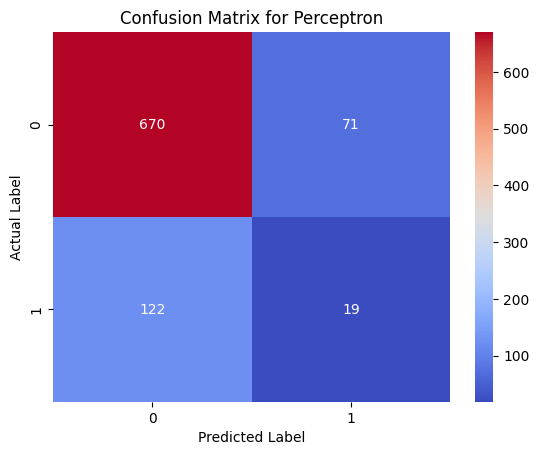
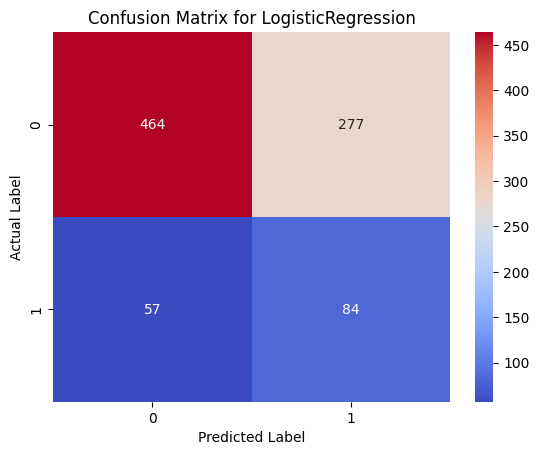
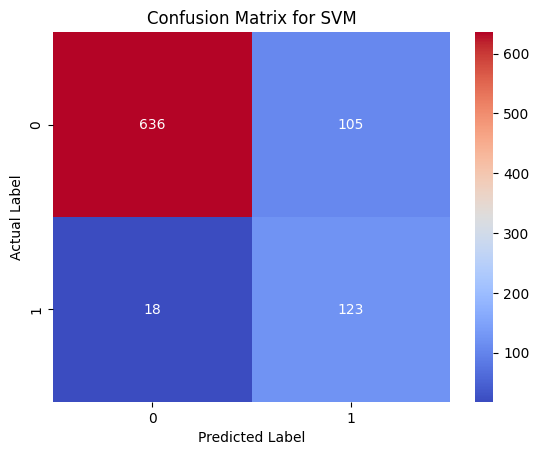
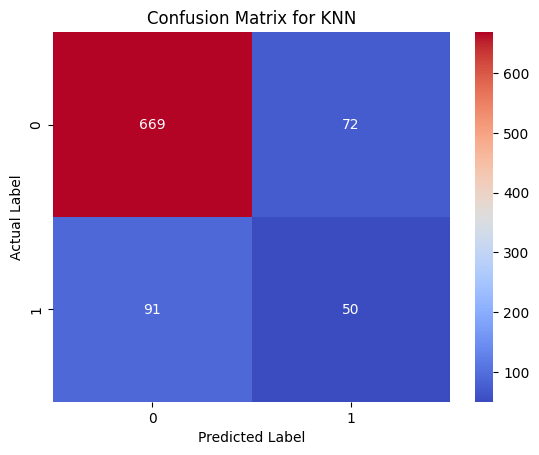
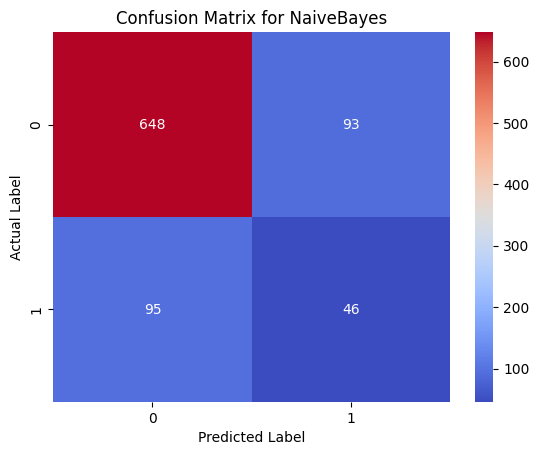
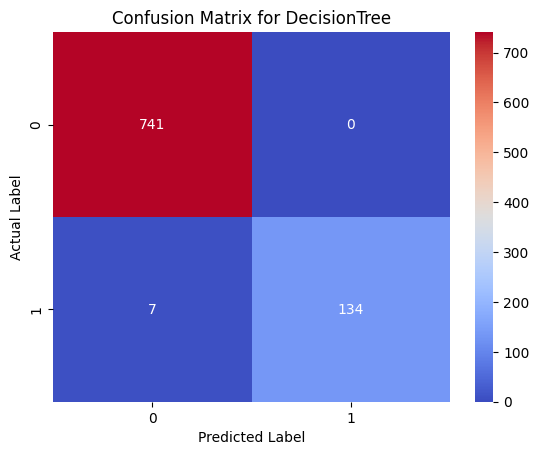
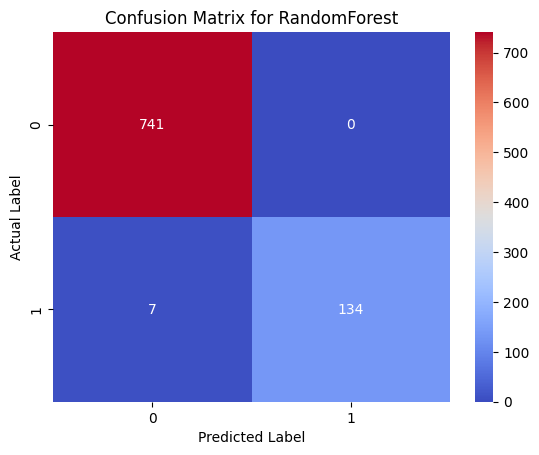

## 7. OPTIMISATION STEPS

**Techniques applied:**
- **Class weighting:** balanced weights in Logistic Regression and SVM to handle ~16% attrition rate.
- **Feature importance:** extracted from Random Forest to identify predictive features.
- **Hyperparameters:** default settings used; future work includes grid search over regularization and tree depth.

**Future optimizations:**
- SMOTE or undersampling to further balance training data.
- Threshold tuning based on business cost (false positive vs false negative).
- Ensemble methods (voting, stacking) combining top models.

## 8. SELECTED MODEL AFTER COMPARING

**Selected model:** Random Forest .

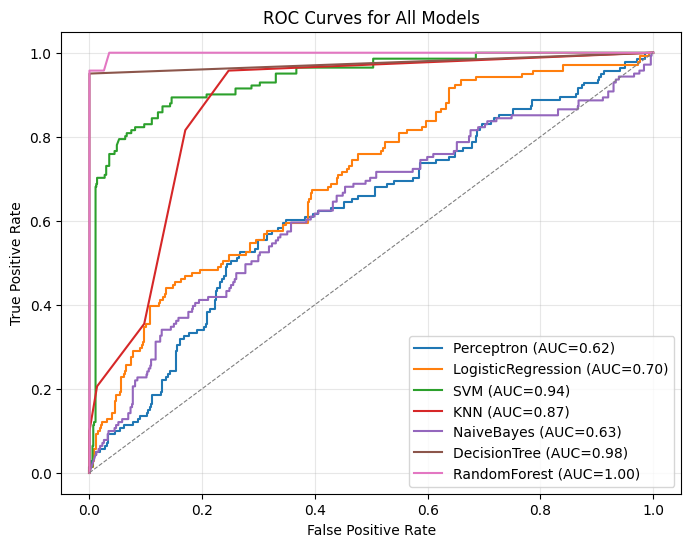  
  
Based on the ROC curve analysis, Random Forest was selected as the final model. Among all the evaluated models, Random Forest achieved the highest AUC score (AUC = 1.00), indicating near-perfect discrimination between the positive and negative classes.

## 9. Analysis of results 

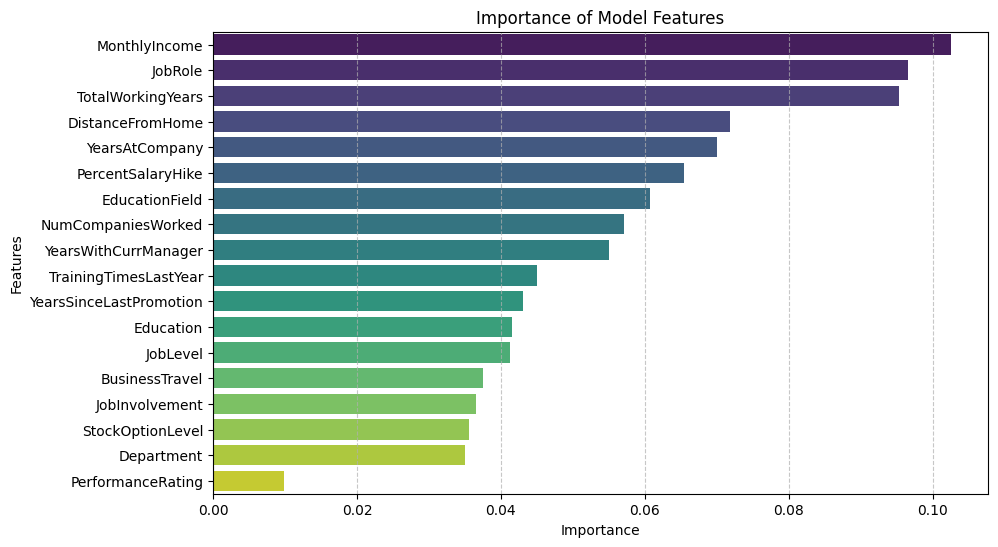  
  
Based on the Random Forest feature importance analysis, the factors with the greatest influence on employee turnover are primarily related to *Monthly Income*, *Job role*, and *Total Working Years*.  

### Most Influential Factors
The top features contributing to employee turnover prediction are:

Monthly Income:  
This is the most influential factor, indicating that employees with lower or less competitive salaries are more likely to leave the organization.  

Job Role:  
Different job roles show varying turnover tendencies, suggesting that role-specific workload, stress levels, or career satisfaction significantly impact attrition.  

Total Working Years:  
Employees’ overall work experience influences turnover, possibly reflecting differences in career stage, expectations, or job stability.  

Distance From Home:  
A longer commute appears to increase the likelihood of employee turnover, highlighting the impact of work–life balance and commuting stress.

Years at Company:  
Employees with fewer years at the company are more prone to leaving, suggesting higher attrition among newer employees.

### Moderately Influential Factors
Factors such as percent salary hike, education field, number of companies worked, and years with current manager also play a meaningful role, indicating that career growth, compensation progression, and managerial relationships affect retention.

### Least Influential Factors

Variables like performance rating, department, and stock option level show relatively low importance, suggesting they have a smaller direct impact on turnover compared to compensation and experience-related factors.
  

# Recommendations

In conclusion, employee turnover is most strongly influenced by financial compensation, job-related characteristics, and career experience. The Random Forest model highlights that improving salary structures, addressing role-specific challenges, supporting early-tenure employees, and reducing commute-related burdens could be effective strategies for reducing employee attrition.